In [1]:
from db_connect import DB_CONN
import setting
import numpy as np
import math
import pandas as pd

In [2]:
class FUNC_CLASS(DB_CONN):

    def __init__(self):
        super().__init__()

    # 取得user的id
    def get_user_id(self,user_unid):
        user_id = 0
        user_sql = "SELECT `id` FROM `ex_user` WHERE `unid` = %s"

        try:
            self.execute(user_sql,[user_unid])
            user_id_arr = self.fetchone()
            user_id = str(user_id_arr['id']) if int(user_id_arr['id']) != 0 else ''
        except:
            user_id = 0

        return user_id

    # 取得user的搜尋紀錄
    def get_this_user_search(self,user_id):
        user_record = {}

        if user_id != '':
            # 取得user 最後搜尋的條件
            user_last_sql = """
                SELECT `area`,`price`,`ping`,`style`,`type`
                FROM `ex_user_record_view`
                WHERE `user_id` = %s 
                ORDER BY `last_time` DESC LIMIT 1
                """
            # 取得user 經常搜尋的條件 (以價格跟坪數篩選)
            user_often_sql = """
                SELECT `area`,`price`,`ping`,`style`,`type`
                FROM `ex_record`
                WHERE `user_id` = %s
                ORDER BY `times` DESC,`price`,`ping` DESC LIMIT 2
                """

            try:
                # 取得user [最後]搜尋的條件
                self.execute(user_last_sql,[user_id])
                user_last_arr = self.fetchone()
                if(user_last_arr != None):
                    user_record['last_record'] = [user_last_arr['area'],user_last_arr['price'],user_last_arr['ping'],user_last_arr['style'],user_last_arr['type']]
                
                # 取得user [經常]搜尋的條件
                self.execute(user_often_sql,[user_id])
                user_often_arr = self.fetchone()

                if user_often_arr != None:
                    user_record['often_record'] = [user_often_arr['area'],user_often_arr['price'],user_often_arr['ping'],user_often_arr['style'],user_often_arr['type']]
            except:
                user_record = {}

        return user_record

In [3]:
    # 取得非user的相同的紀錄
    def get_same_record(self,user_id,record):
        record_arr = {}

        # 取得user record
        record_sql = """
            SELECT  `record_times`,`main_id`,`items_times`,`click_map`,
                    `add_favorite`,`item_stay_time`,`map_stay_time`
            FROM    `ex_user_record_view` 
            WHERE   `user_id` != %s AND
                    `area`    = %s AND
                    `price`   = %s AND
                    `ping`    = %s AND
                    `style`   = %s AND
                    `type`    = %s 
            ORDER BY `item_stay_time`
            """

        record_vals = [
                user_id,record[0],
                record[1],record[2],record[3],
                record[4]]
        try:
            if(record):
                self.execute(record_sql,record_vals)
                record_arr = self.fetchall()
        except:
            record_arr = {}

        return record_arr

In [9]:
    # 取得瀏覽物件的時間區間(單位:秒)
    def get_times_range(self,user_id,record):
        range_arr = {}

        record_sql = """
            SELECT  items.click_map,items.add_favorite,items.main_id,
                    IFNULL(
                        (SELECT SUM(`stay_time`) 
                        FROM    `ex_record_items_stay` items_stay
                        WHERE   items_stay.`record_items_id` = items.`id` AND
                                `stay_time` > %s
                    ),0) AS 'all_seconds'
            FROM `ex_record` record,`ex_record_items` items 
            WHERE items.`record_id` = record.`id` AND
                  items.`user_id` = record.`user_id` AND
                  record.`user_id` = %s AND
                  record.`area`    = %s AND
                  record.`price`   = %s AND
                  record.`ping`    = %s AND
                  record.`style`   = %s AND
                  record.`type`    = %s AND
                  record.`times`   > %s
            """
        record_vals = [
                setting.view_seconds,user_id,record[0],
                record[1],record[2],record[3],
                record[4],setting.search_times
        ]
        #try:
        self.execute(record_sql,record_vals)
        record_arr = self.fetchall()

        #print(record_arr)

            #times_arr = []
            #if record_arr:
            #    for record in record_arr:
            #        times_arr.append(record['all_seconds'])
            #        times_arr.sort()
            #    
            #    if times_arr:
            #        # 取得中位數的前後值
            #        range_arr = self.get_median_range(times_arr)   
        #except:
            #range_arr = {}

        return range_arr

In [10]:
    # 取得中位數的前後值
    def get_median_range(self,times_arr):
        range_arr = {}
        times_arr_len = len(times_arr)

        if times_arr_len == 1:
            range_arr['seconds_start'] = times_arr[0]
            range_arr['seconds_end'] = times_arr[0]
        elif times_arr_len == 2:
            range_arr['seconds_start'] = times_arr[0]
            range_arr['seconds_end'] = times_arr[1]
        elif times_arr_len%2 == 0:
            median_index = (times_arr_len / 2)
            range_arr['seconds_start'] = times_arr[median_index - 1]
            range_arr['seconds_end'] = times_arr[median_index + 1]
        elif times_arr_len%2 != 0:
            median_index = math.floor(times_arr_len / 2)
            range_arr['seconds_start'] = times_arr[median_index - 1]

            median_index = math.ceil(times_arr_len / 2)
            range_arr['seconds_end'] = times_arr[median_index]

        return range_arr

In [11]:
    # 取得分位數
    def quantile(data,percent):
        p_index = int(percent * len(data))
        return sorted(data)[p_index]

In [12]:
    # 取得該User是否有加入最愛的習慣
    def get_is_favorite(self,user_id):
        return ''

In [15]:
import pandas as pd
import sys

In [41]:
#data = [1,1,1,1,99,99,99]
data = [1,2,3,4,20,30,35,100,101,102,200,400,1000,2000,20000]
#data = [1,2,3,4,30,40,35,100]

newdf = pd.DataFrame(data, columns=['second'])

# abs:絕對值;  abs(X - 平均值)
newdf['x-Mean'] = abs(newdf['second'] - newdf['second'].mean())
# std:標準差，有 95% 信心估計母群體平均數，在樣本平均數 ± 1.96 * (母群體標準差 / 樣本數 n 的平方根) 的範圍內。
newdf['1.96*std'] = 1.96*newdf['second'].std()  
newdf['Outlier'] = abs(newdf['second'] - newdf['second'].mean()) > 1.96*newdf['second'].std()
newdf

,second,x-Mean,1.96*std,Outlier
0,1,1598.866667,10032.984361,False
1,2,1597.866667,10032.984361,False
2,3,1596.866667,10032.984361,False
3,4,1595.866667,10032.984361,False
4,20,1579.866667,10032.984361,False
5,30,1569.866667,10032.984361,False
6,35,1564.866667,10032.984361,False
7,100,1499.866667,10032.984361,False
8,101,1498.866667,10032.984361,False
9,102,1497.866667,10032.984361,False


In [67]:
data = {'user_id': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 
        'record_times': [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], 
        'main_id': [10, 8, 10, 8, 10, 10, 10, 8, 10, 8, 10, 10, 10, 8, 19, 10, 8], 
        'items_times': [10, 6, 10, 6, 10, 10, 10, 6, 10, 6, 10, 10, 10, 6, 8, 10, 6], 
        'click_map': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
        'add_favorite': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
        'item_stay_time': [30, 30, 40, 65, 65, 80, 110, 120, 120, 150, 150, 200, 300, 300, 500, 600, 700], 
        'map_stay_time': [60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60]}

df = pd.DataFrame(data)
df

,add_favorite,click_map,item_stay_time,items_times,main_id,map_stay_time,record_times,user_id
0,1,1,30,10,10,60,5,2
1,1,1,30,6,8,60,5,2
2,1,1,40,10,10,60,5,2
3,1,1,65,6,8,60,5,2
4,1,1,65,10,10,60,5,2
5,1,1,80,10,10,60,5,2
6,1,1,110,10,10,60,5,2
7,1,1,120,6,8,60,5,2
8,1,1,120,10,10,60,5,2
9,1,1,150,6,8,60,5,2


In [68]:
df_groupby = df.groupby(['user_id','add_favorite','click_map','main_id'])
df_groupby_sum = df_groupby.sum()
print(df_groupby_sum)

                                        item_stay_time  items_times  \
user_id add_favorite click_map main_id                                
2       1            1         8                  1365           36   
                               10                 1695          100   
                               19                  500            8   

                                        map_stay_time  record_times  
user_id add_favorite click_map main_id                               
2       1            1         8                  360            30  
                               10                 600            50  
                               19                  60             5  


In [62]:
df = pd.DataFrame(data, columns=['item_stay_time'])

# abs:絕對值;  abs(X - 平均值)
df['x-Mean'] = abs(df['item_stay_time'] - df['item_stay_time'].mean())
# std:標準差，有 95% 信心估計母群體平均數，在樣本平均數 ± 1.96 * (母群體標準差 / 樣本數 n 的平方根) 的範圍內。
df['1.96*std'] = 1.96*df['item_stay_time'].std()  
df['Outlier'] = abs(df['item_stay_time'] - df['item_stay_time'].mean()) > 1.96*df['item_stay_time'].std()

df

,item_stay_time,x-Mean,1.96*std,Outlier
0,30,179.411765,403.661309,False
1,30,179.411765,403.661309,False
2,40,169.411765,403.661309,False
3,65,144.411765,403.661309,False
4,65,144.411765,403.661309,False
5,80,129.411765,403.661309,False
6,110,99.411765,403.661309,False
7,120,89.411765,403.661309,False
8,120,89.411765,403.661309,False
9,150,59.411765,403.661309,False


In [69]:
import matplotlib.pyplot as plt
import datetime

In [83]:
data = {'user_id': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 
        'record_times': [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], 
        'main_id': [10, 8, 10, 8, 10, 10, 10, 8, 10, 8, 10, 10, 10, 8, 19, 10, 8], 
        'items_times': [10, 6, 10, 6, 10, 10, 10, 6, 10, 6, 10, 10, 10, 6, 8, 10, 6], 
        'click_map': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
        'add_favorite': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
        'item_stay_time': [30, 30, 40, 65, 65, 80, 110, 120, 120, 150, 150, 200, 300, 300, 500, 600, 700], 
        'map_stay_time': [60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60]}

df = pd.DataFrame(data)
df

,add_favorite,click_map,item_stay_time,items_times,main_id,map_stay_time,record_times,user_id
0,1,1,30,10,10,60,5,2
1,1,1,30,6,8,60,5,2
2,1,1,40,10,10,60,5,2
3,1,1,65,6,8,60,5,2
4,1,1,65,10,10,60,5,2
5,1,1,80,10,10,60,5,2
6,1,1,110,10,10,60,5,2
7,1,1,120,6,8,60,5,2
8,1,1,120,10,10,60,5,2
9,1,1,150,6,8,60,5,2


<Container object of 17 artists>

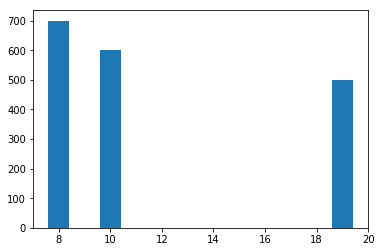

In [86]:
#top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
plt.bar(df['main_id'],df["item_stay_time"])
#top.plot(df["item_stay_time"],df['main_id'])
#plt.title('Yahoo Price from 2007 - 2012')

([<matplotlib.patches.Wedge at 0x2436b796128>,
 [Text(1.05271,0.319071,'day1'),
  Text(0.531205,0.963235,'day2'),
  Text(-0.696995,0.914712,'day3'),
  Text(-1.09497,-0.10505,'day3'),
  Text(-0.62743,-0.90351,'day5'),
  Text(0.747201,-0.807274,'day6')],
 [Text(0.574204,0.174039,'9.4%'),
  Text(0.289748,0.525401,'15.2%'),
  Text(-0.393954,0.517011,'21.5%'),
  Text(-0.597258,-0.0573,'10.8%'),
  Text(-0.342235,-0.492824,'16.9%'),
  Text(0.407564,-0.440331,'26.2%')])

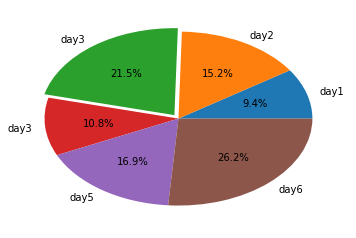

In [87]:
fig = plt.figure()
labels = ["day1","day2","day3","day3","day5","day6"]
word_size = [2000, 3250, 4600 , 2300, 3600, 5600]
explode = [0 , 0, .05, 0, 0, 0]  #0則不突凸出，值越大 則凸出越大
plt.pie(word_size, explode= explode, labels = labels, autopct= "%3.1f%%")

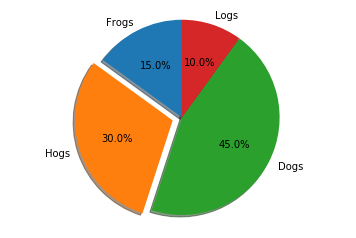

In [99]:
labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
sizes = [15, 30, 45, 10]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

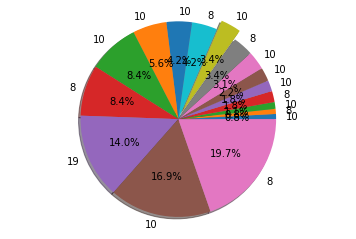

In [98]:
labels = df['main_id']
sizes = df["item_stay_time"]

explode = (0,0,0,0,0,0,0,0, 0.1, 0, 0,0,0,0,0,0,0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()